In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import os
import warnings
import pickle
import pysam
import numpy as np
from dragonn.interpret import * 
from dragonn.vis import * 
from keras.models import load_model
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1
from keras.models import load_model
from kerasAC.metrics import recall, specificity, fpr, fnr, precision, f1
from kerasAC.custom_losses import ambig_binary_crossentropy, ambig_mean_squared_error

Using TensorFlow backend.
W0723 02:40:52.912177 140322143303488 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



## Select GPU

In [3]:
warnings.filterwarnings('ignore')
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
!env | grep "CUDA"

grep: warning: GREP_OPTIONS is deprecated; please use an alias or script
CUDA_VISIBLE_DEVICES=0
CUDA_HOME=/usr/local/cuda-10.0


## Get Model Addresses

In [4]:
samples=open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/merged_tagAligns_outputs/samples.txt','r').read().strip().split('\n')
model_dict={}
idr_dict={}
for sample in samples:
    print(sample)
    model_dict[sample]='/mnt/lab_data3/soumyak/adpd/deeplearning/models/regression/mean/'+sample+'.model.'

AD_ADAD_CAUD
AD_ADAD_HIPP
AD_ADAD_PARL
AD_ADAD_SMTG
AD_CTRH_CAUD
AD_CTRH_HIPP
AD_CTRH_PARL
AD_CTRH_SMTG
AD_CTRL_CAUD
AD_CTRL_HIPP
AD_CTRL_PARL
AD_CTRL_SMTG
AD_LOAD_CAUD
AD_LOAD_HIPP
AD_LOAD_PARL
AD_LOAD_SMTG
PD_CTRL_CAUD
PD_CTRL_HIPP
PD_CTRL_MDFG
PD_CTRL_MDTG
PD_CTRL_PTMN
PD_CTRL_SUNI
PD_GBA1_CAUD
PD_GBA1_HIPP
PD_GBA1_MDFG
PD_GBA1_MDTG
PD_GBA1_PTMN
PD_GBA1_SUNI
PD_LOPD_CAUD
PD_LOPD_HIPP
PD_LOPD_MDFG
PD_LOPD_MDTG
PD_LOPD_PTMN
PD_LOPD_SUNI
PD_LRRK_CAUD
PD_LRRK_HIPP
PD_LRRK_MDFG
PD_LRRK_MDTG
PD_LRRK_PTMN
PD_LRRK_SUNI


## Function to get Inputs for SNPs

In [5]:
# SNP is at position 101 in the 200 bp MPRA construct 
ref_fasta="/mnt/data/annotations/by_release/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"

def get_inputs(chrom,snp_pos,flank=100,ref=ref_fasta):
    ref=pysam.FastaFile(ref)
    ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1],'N':[0,0,0,0]}
    snp_pos=snp_pos-1 #convert to 0-indexing
    left_flank=ref.fetch(chrom,snp_pos-flank,snp_pos)
    print(left_flank[-10::])
    right_flank=ref.fetch(chrom,snp_pos+1,snp_pos+flank)
    print(right_flank[0:10])
    encoded=dict() 
    seqs=dict()
    for base in ['A','C','G','T']: 
        curseq=left_flank+base+right_flank
        seqs[base]=curseq
        encoded[base]=np.expand_dims(np.expand_dims(np.array([ltrdict.get(x,[0,0,0,0]) for x in curseq]),0),0)
    return encoded,seqs

## Function to get Inputs for Indels

In [6]:
def get_inputs_mod(chrom,snp_pos,flank=100,ref=ref_fasta):
    ref=pysam.FastaFile(ref)
    ltrdict = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0],'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1],'N':[0,0,0,0]}
    snp_pos=snp_pos-1 #convert to 0-indexing
    left_flank=ref.fetch(chrom,snp_pos-flank,snp_pos)
    print(left_flank[-10::])
    right_flank=ref.fetch(chrom,snp_pos+1,snp_pos+flank)
    print(right_flank[0:10])
    encoded=dict() 
    seqs=dict()
    for base in ['A','C','G','T']: 
        curseq=left_flank+base+right_flank
        seqs[base]=curseq
        encoded[base]=np.expand_dims(np.expand_dims(np.array([ltrdict.get(x,[0,0,0,0]) for x in curseq]),0),0)
    right_flank=ref.fetch(chrom,snp_pos+3,snp_pos+flank+2)
    curseq=left_flank+'C'+right_flank
    seqs['del']=curseq
    encoded['del']=np.expand_dims(np.expand_dims(np.array([ltrdict.get(x,[0,0,0,0]) for x in curseq]),0),0)
    return encoded,seqs

## Select SNP and Task

In [7]:
snp='rs2732614'
fold=7
snp_chrom="chr17"
snp_pos=46286843
ref='C'
alt='T'
task='AD_CTRL_SMTG'

## Load Model

In [8]:
##load the model 
custom_objects={"recall":recall,
                "sensitivity":recall,
                "specificity":specificity,
                "fpr":fpr,
                "fnr":fnr,
                "precision":precision,
                "f1":f1,
                "ambig_binary_crossentropy":ambig_binary_crossentropy,
                "ambig_mean_squared_error":ambig_mean_squared_error}
model_prefix=model_dict[task]
model=load_model(model_prefix+str(fold),custom_objects=custom_objects)

W0723 02:40:53.451413 140322143303488 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 02:40:53.456000 140322143303488 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 02:40:53.482793 140322143303488 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 02:40:53.484251 140322143303488 deprecation_wrapper.py:119] From /users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_defa

## Get Inputs

In [9]:
#Now, pad to 1000 bp by using a 500 bp flank 
X,seqs=get_inputs_mod(snp_chrom,snp_pos,flank=500)
X[ref].shape

CTCACTGCTG
CCTCTTGTGC


(1, 1, 1000, 4)

## Get DeepLIFT Scoring Function

In [10]:
score_func=get_deeplift_scoring_function(model_prefix+str(fold),
                                         target_layer_idx=-1)

## Get Reference Interpretations

getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value


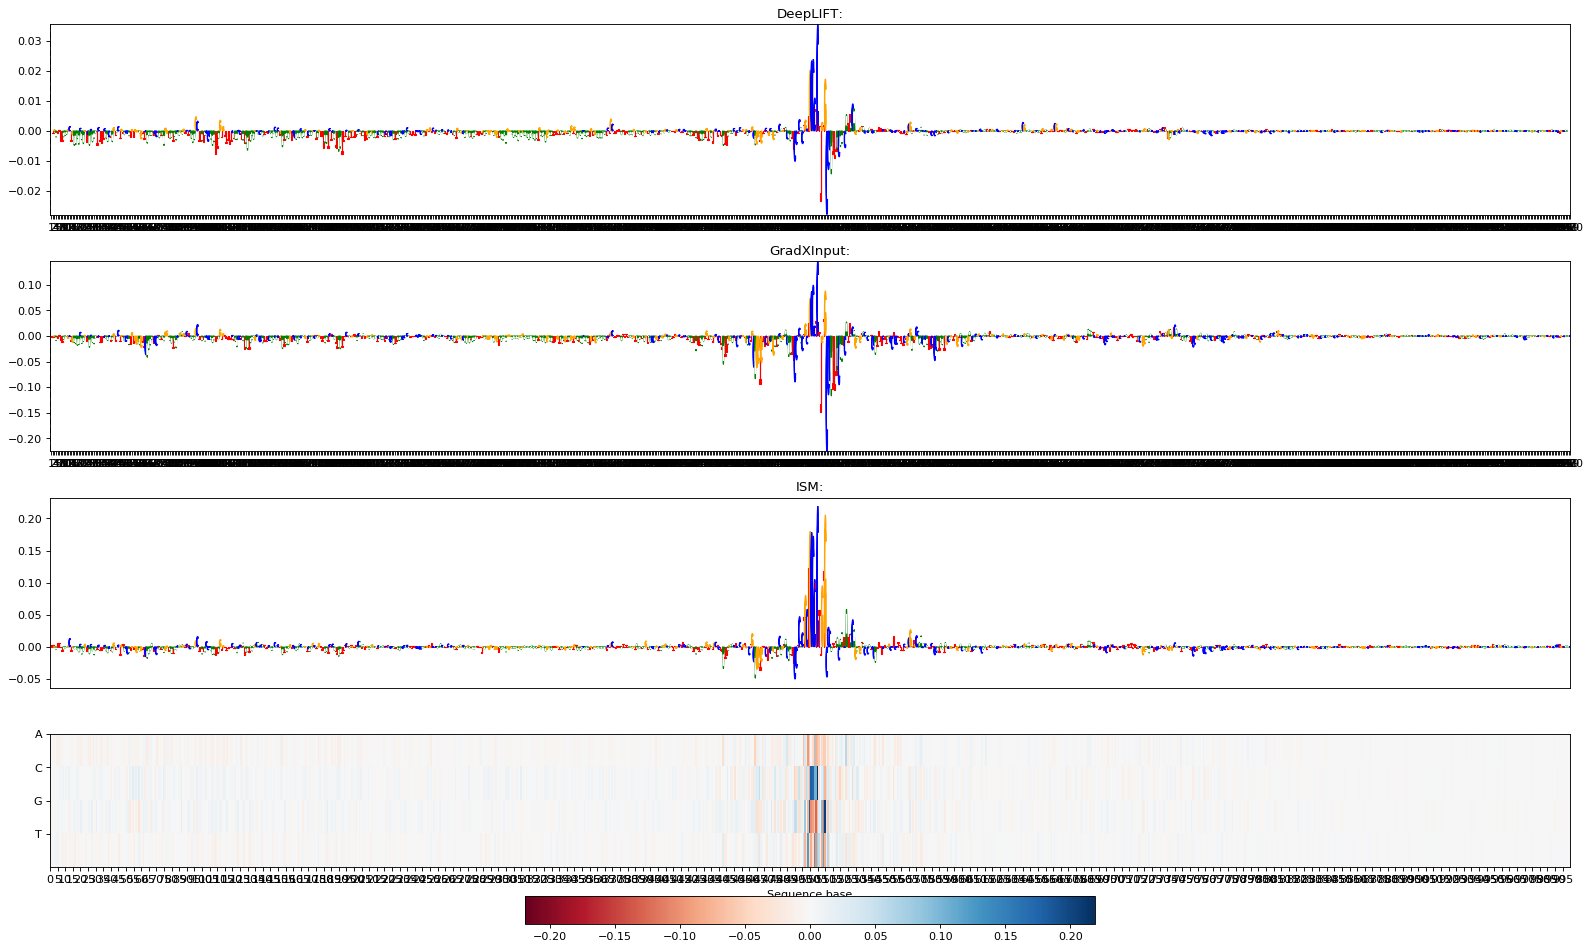

In [11]:
interpretations_ref=multi_method_interpret(model,
                                      X[ref],
                                      task_idx=0,
                                      deeplift_score_func=score_func,
                                      target_layer_idx=-1)

## Zoom In to Locus of Interest: Reference

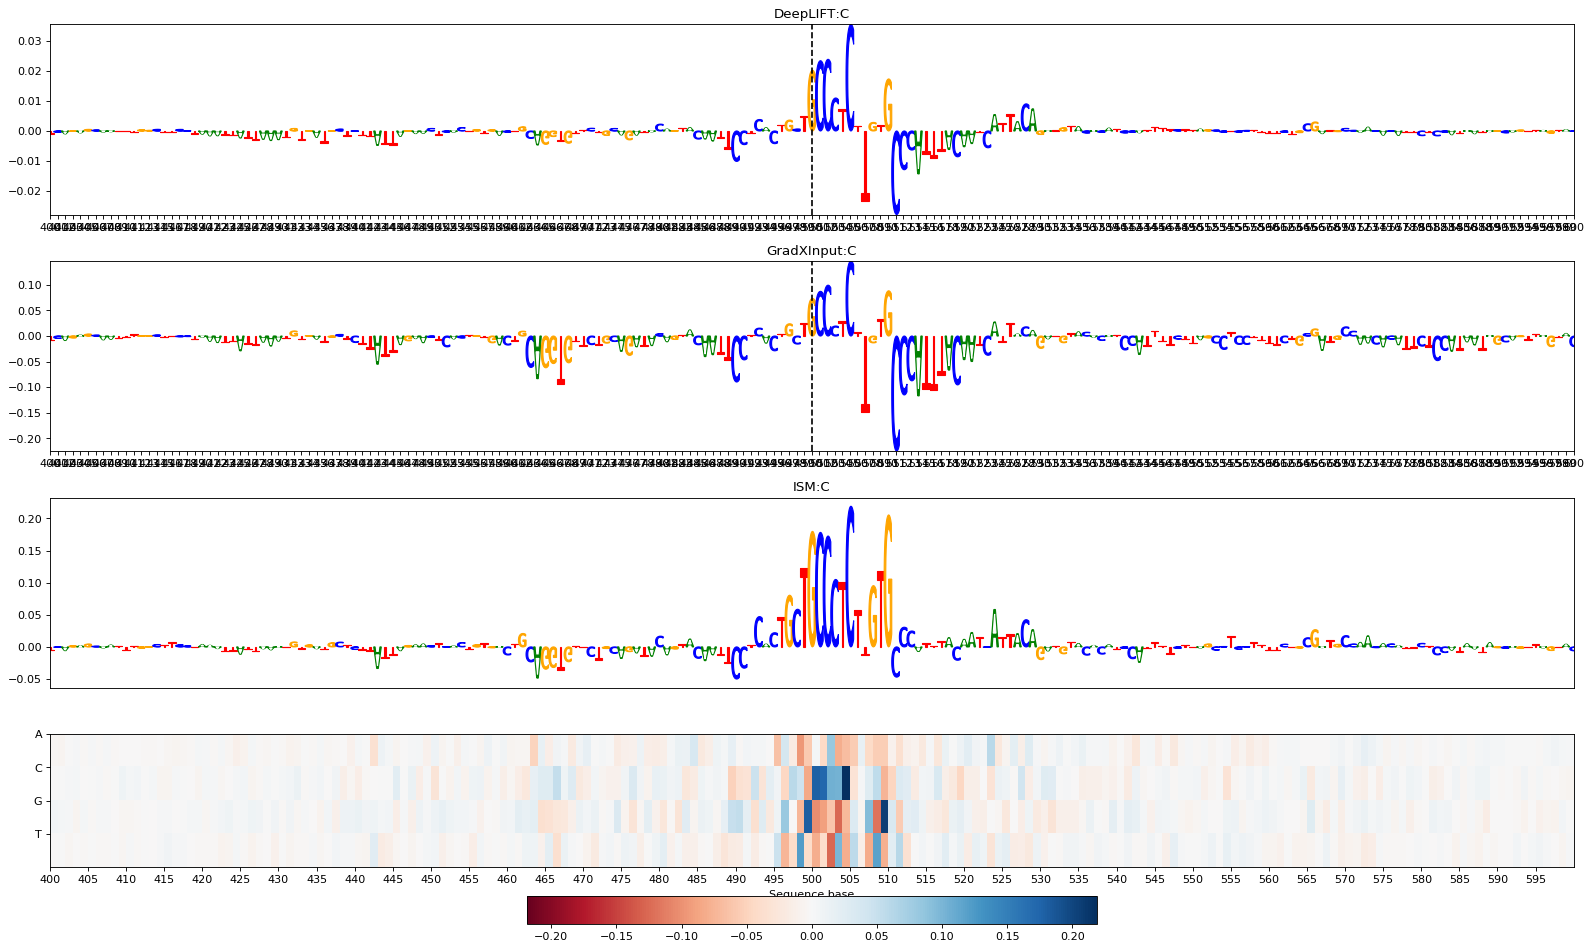

In [12]:
plot_all_interpretations([interpretations_ref],X[ref],title=ref,xlim=(400,600),snp_pos=500)

## Get Alternate Interpretations

getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value


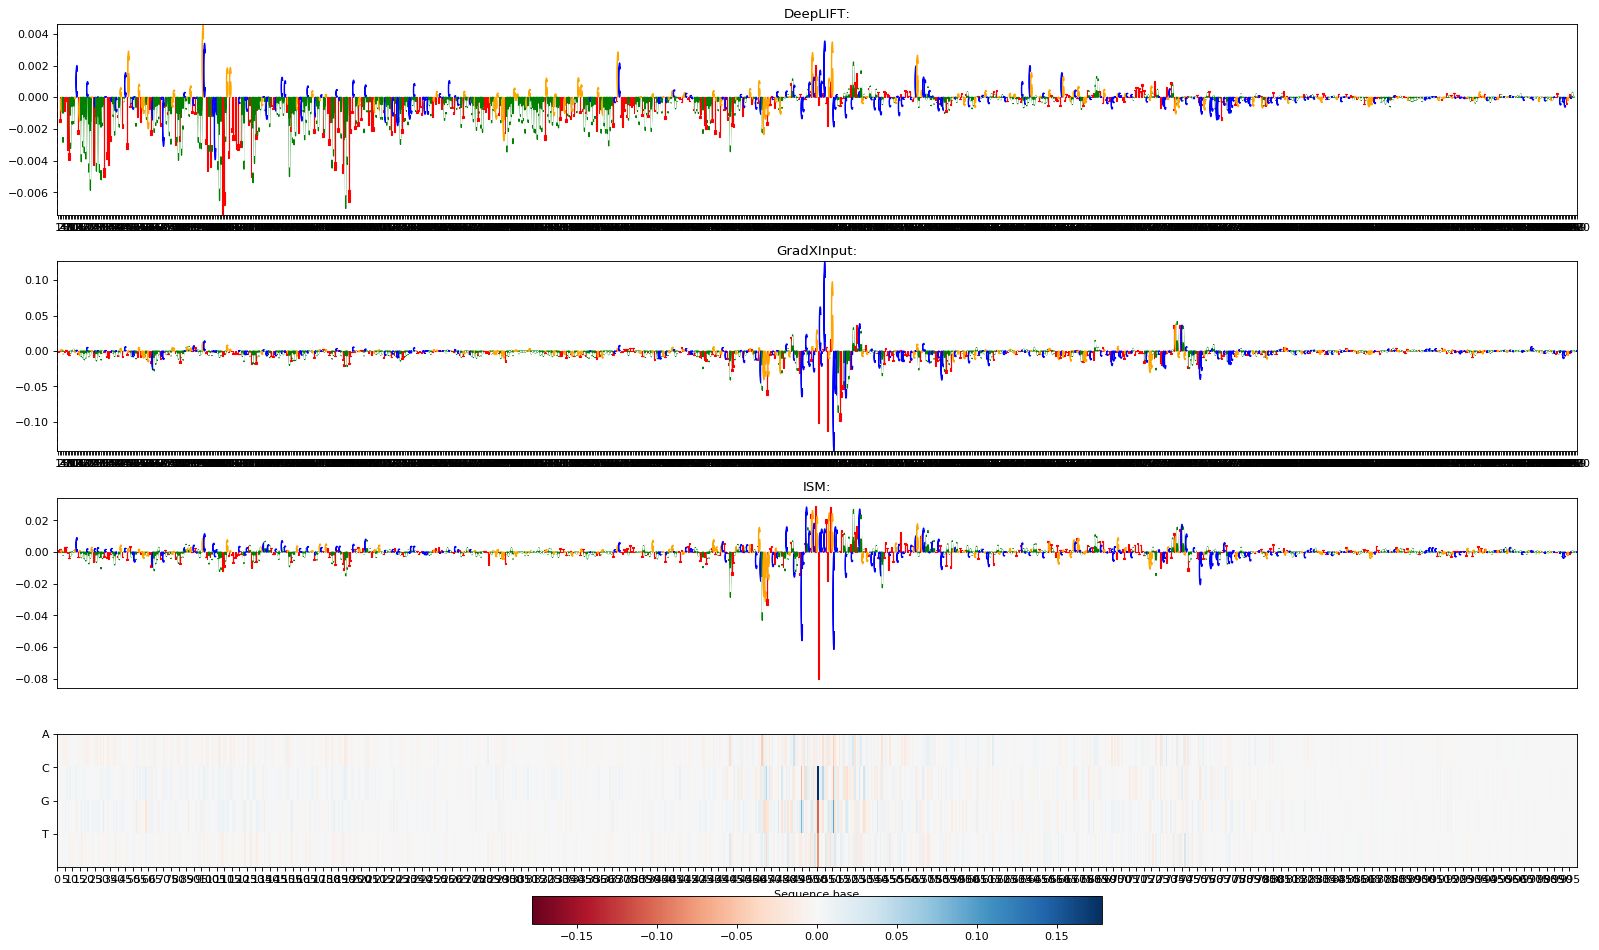

In [13]:
interpretations_alt=multi_method_interpret(model,
                                      X[alt],
                                      task_idx=0,
                                      deeplift_score_func=score_func,
                                      target_layer_idx=-1)

## Zoom In to Locus of Interest: Alternate

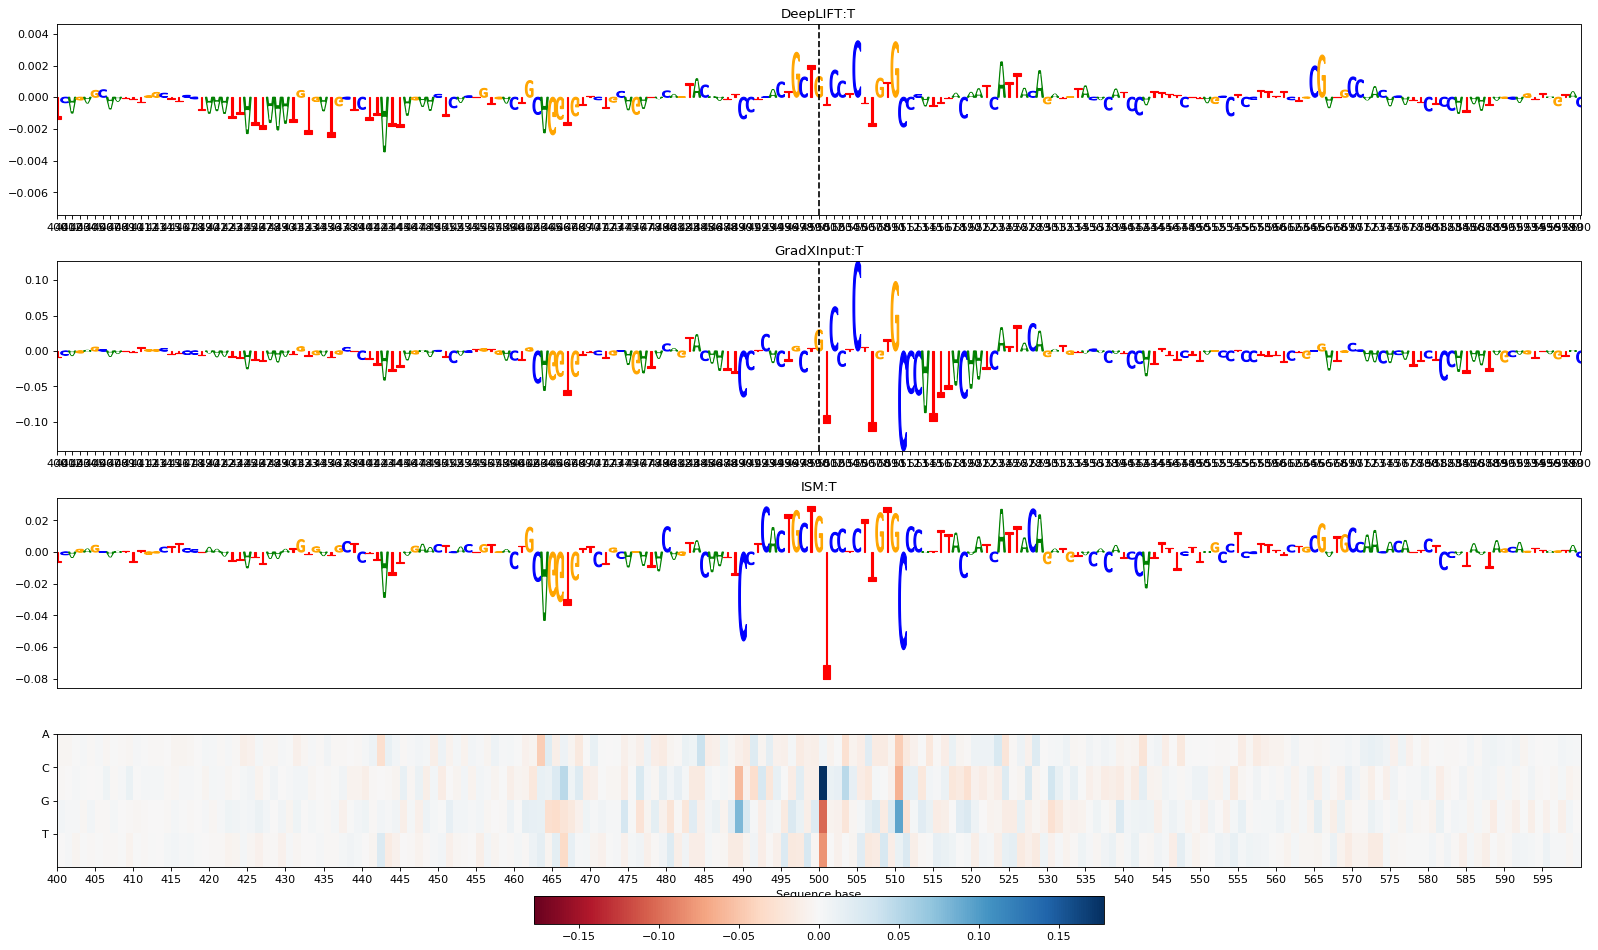

In [14]:
plot_all_interpretations([interpretations_alt],X[alt],title=alt,xlim=(400,600),snp_pos=500)


## Compare Reference and Alternate SNPs

In [15]:
def plot_snp_interpretation_(ref_interp_dict_list,                               
                    alt_interp_dict_list,                                       
                    ref_X,                                                      
                    alt_X,                                                      
                    xlim=None,                                                  
                    figsize=(20,3),                                             
                    title=None,                                                 
                    out_fname_svg=None,                                                                                                                                                                     
                    snp_pos=0):                                                                                            
    num_samples=len(ref_interp_dict_list)                                       
    if title==None:                                                             
        title=["" for i in range(num_samples)]                                  
    if xlim==None:                                                              
        xlim=(0,ref_X.squeeze().shape[0])                                       
    f,axes=plt.subplots(9,num_samples, dpi=80,figsize=(figsize[0],figsize[1]*9))
    if num_samples==1:                                                          
        axes=np.expand_dims(axes,axis=1)                                        
    axes = np.array(axes)                                                       
    ism_ref_axes=axes[0:2,:]
    ism_alt_axes=axes[2:4,:]
    input_grad_ref_axes=axes[4,:]                                                   
    input_grad_alt_axes=axes[5,:]
    deeplift_ref_axes=axes[6,:]                                                 
    deeplift_alt_axes=axes[7,:]                                                 
    deeplift_delta_axes=axes[8,:]
    
    for sample_index in range(num_samples):                                     
        ism_ref_axes[:,sample_index]=plot_ism(ref_interp_dict_list[sample_index]['ism'],
                                          ref_X,                                
                                          title=':'.join(["ISM",ref]),
                                          figsize=figsize,                      
                                          xlim=xlim,                            
                                          axes=ism_ref_axes[:,sample_index])
        ism_alt_axes[:,sample_index]=plot_ism(alt_interp_dict_list[sample_index]['ism'],
                                          alt_X,                                
                                          title=':'.join(["ISM",alt]),
                                          figsize=figsize,                      
                                          xlim=xlim,                            
                                          axes=ism_alt_axes[:,sample_index])
        input_grad_ref_axes[sample_index]=plot_seq_importance(ref_interp_dict_list[sample_index]['input_grad'],
                                                          ref_X,                
                                                          title=":".join(["GradXInput",ref]),
                                                          figsize=figsize,      
                                                          xlim=xlim,            
                                                          axes=input_grad_ref_axes[sample_index])
        input_grad_alt_axes[sample_index]=plot_seq_importance(alt_interp_dict_list[sample_index]['input_grad'],
                                                          alt_X,                
                                                          title=":".join(["GradXInput",alt]),
                                                          figsize=figsize,      
                                                          xlim=xlim,            
                                                          axes=input_grad_alt_axes[sample_index])
        deeplift_ref_axes[sample_index]=plot_seq_importance(ref_interp_dict_list[sample_index]['deeplift'],
                                                            ref_X,              
                                                            title=":".join(["Ref DeepLIFT",ref]),
                                                            figsize=figsize,    
                                                            xlim=xlim,          
                                                            snp_pos=snp_pos,    
                                                            axes=deeplift_ref_axes[sample_index])
        deeplift_alt_axes[sample_index]=plot_seq_importance(alt_interp_dict_list[sample_index]['deeplift'],
                                                            alt_X,              
                                                            title=":".join(["Alt DeepLIFT",alt]),
                                                            figsize=figsize,    
                                                            xlim=xlim,          
                                                            snp_pos=snp_pos,    
                                                            axes=deeplift_alt_axes[sample_index])
        deeplift_delta_axes[sample_index]=plot_seq_importance(alt_interp_dict_list[sample_index]['deeplift'] - ref_interp_dict_list[sample_index]['deeplift'],
                                                              alt_X,            
                                                              title=":".join(["Alt - Ref DeepLIFT", alt + ' - ' + ref]),
                                                              figsize=figsize,  
                                                              xlim=xlim,        
                                                              snp_pos=snp_pos,  
                                                              axes=deeplift_delta_axes[sample_index])
        
        if out_fname_svg is not None:
            plt.savefig(out_fname_svg,dpi=80,format="svg")
        f.show()

## Get Comparisons

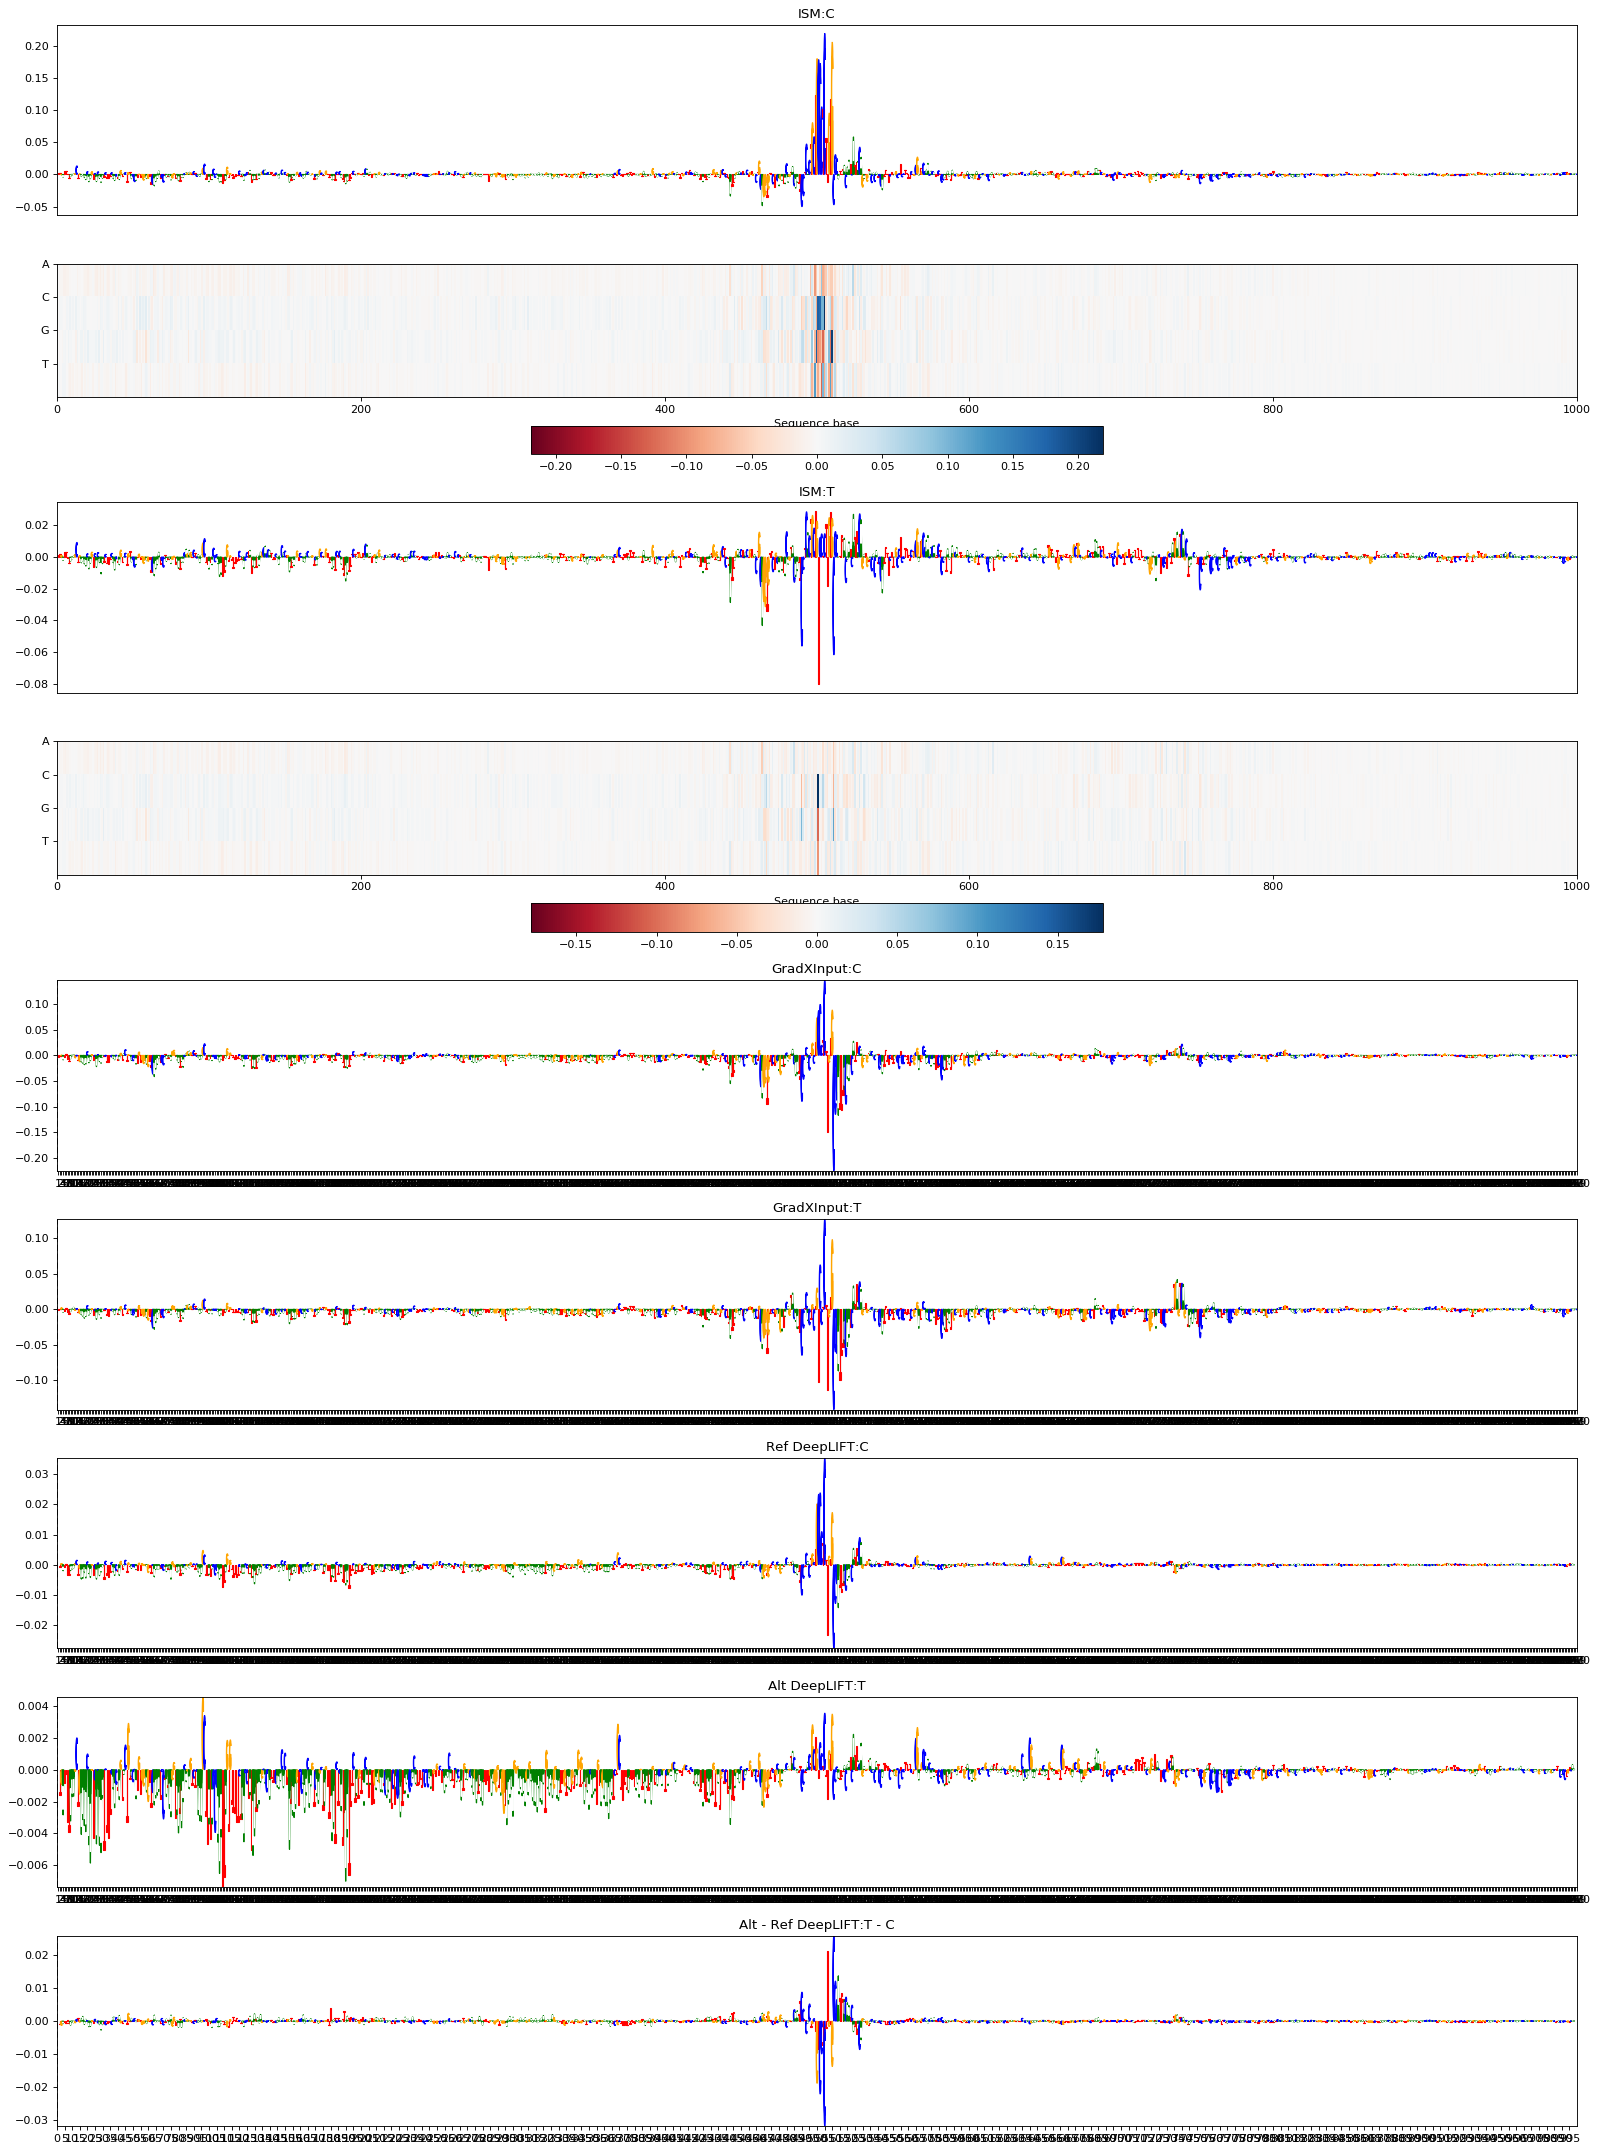

In [16]:
plot_snp_interpretation_([interpretations_ref],[interpretations_alt],X[ref],X[alt])

## Zoom In: Comparisons

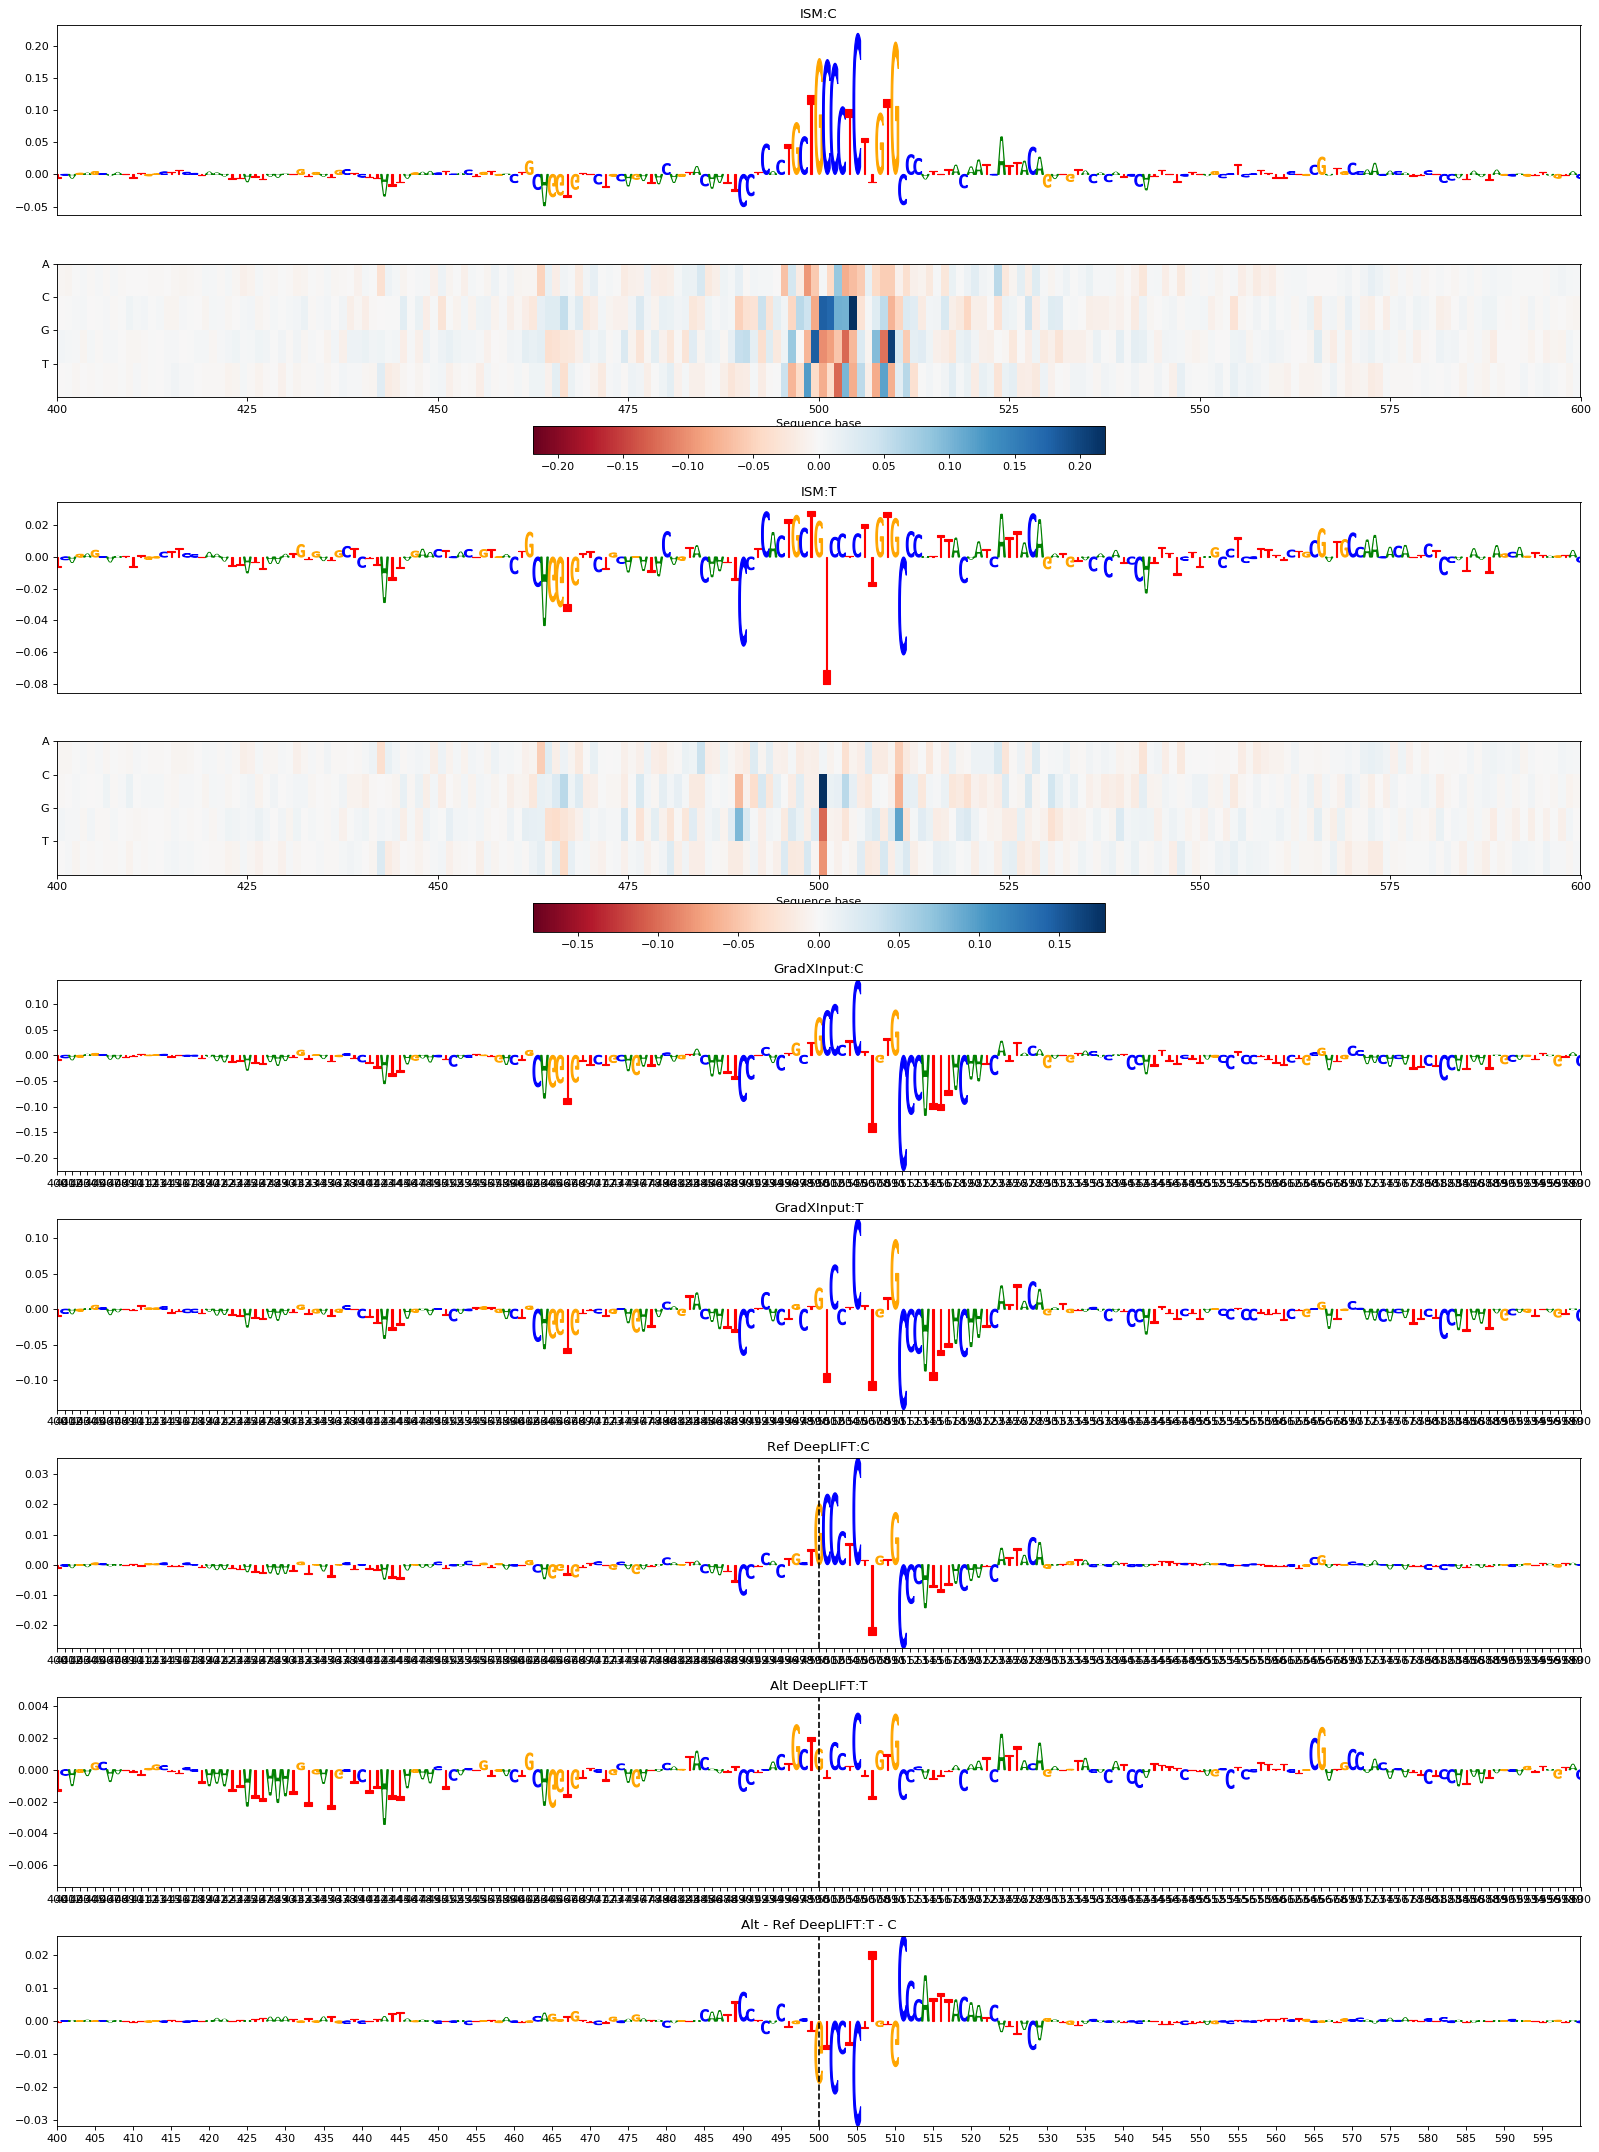

In [17]:
plot_snp_interpretation_([interpretations_ref],[interpretations_alt],X[ref],X[alt],xlim=(400,600),snp_pos=500)